<a href="https://colab.research.google.com/github/fewewra/CNN_plant_diseases/blob/main/CNN_plants_diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Создание дирректории для файла ключа

In [ ]:
# Kaggle
!pip install -q kaggle

from google.colab import files

print("Пожалуйста, загрузите ваш файл kaggle.json")
files.upload()

# Ключ api в папке .kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Права доступа
!chmod 600 ~/.kaggle/kaggle.json

print("\nAPI ключ Kaggle успешно установлен!")

Пожалуйста, загрузите ваш файл kaggle.json


Saving kaggle.json to kaggle.json

API ключ Kaggle успешно установлен!


# Скачивание дата сета

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset -q
# Флаг -n чтобы не перезаписывать файлы, если они уже есть
!unzip -q -n new-plant-diseases-dataset.zip
print("Датасет успешно скачан и распакован.")

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
Датасет успешно скачан и распакован.


# Установка констант и импорт библиотек

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Политика смешанной точности (Mixed Precision) установлена.")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Определяем основные константы
# Пути к данным
# На Kaggle путь к папке 'test' неверный
BASE_DATASET_DIR = 'New Plant Diseases Dataset(Augmented)'
TRAIN_DIR = os.path.join(BASE_DATASET_DIR, 'New Plant Diseases Dataset(Augmented)', 'train')
VALID_DIR = os.path.join(BASE_DATASET_DIR, 'New Plant Diseases Dataset(Augmented)', 'valid')

TEST_DIR = VALID_DIR

# Параметры изображений
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Размер батча
BATCH_SIZE = 128

print("Библиотеки импортированы, константы определены.")

Политика смешанной точности (Mixed Precision) установлена.
Библиотеки импортированы, константы определены.


# Проверка дирректорий на наличие

In [ ]:
print("Содержимое текущей директории:")
!ls -l

# Проверка не обязательна, выполнялась в рамках диагности ранего прекращения работы блокнота из=за лимитов
DATASET_FOLDER_NAME = 'New Plant Diseases Dataset(Augmented)'
if os.path.exists(DATASET_FOLDER_NAME):
    print(f"\nПапка '{DATASET_FOLDER_NAME}' найдена!")
    print("Содержимое этой папки:")
    !ls -l '{DATASET_FOLDER_NAME}'

    TRAIN_SUBDIR = os.path.join(DATASET_FOLDER_NAME, 'train')
    VALID_SUBDIR = os.path.join(DATASET_FOLDER_NAME, 'valid')

    if os.path.exists(TRAIN_SUBDIR):
        print(f"\nПодпапка '{TRAIN_SUBDIR}' найдена!")
    else:
        print(f"\nВНИМАНИЕ: Подпапка '{TRAIN_SUBDIR}' НЕ найдена!")

    if os.path.exists(VALID_SUBDIR):
        print(f"\nПодпапка '{VALID_SUBDIR}' найдена!")
    else:
        print(f"\nВНИМАНИЕ: Подпапка '{VALID_SUBDIR}' НЕ найдена!")

else:
    print(f"\nВНИМАНИЕ: Папка '{DATASET_FOLDER_NAME}' НЕ найдена!")
    print("Возможно, она называется по-другому? Проверьте список файлов выше.")

Содержимое текущей директории:
total 2829820
-rw-r--r-- 1 root root         64 Jun 19 11:57  kaggle.json
drwxr-xr-x 3 root root       4096 Jun 19 11:58 'new plant diseases dataset(augmented)'
drwxr-xr-x 3 root root       4096 Jun 19 11:58 'New Plant Diseases Dataset(Augmented)'
-rw-r--r-- 1 root root 2897709187 Oct 12  2019  new-plant-diseases-dataset.zip
drwxr-xr-x 1 root root       4096 Jun 17 13:37  sample_data
drwxr-xr-x 3 root root       4096 Jun 19 11:59  test

Папка 'New Plant Diseases Dataset(Augmented)' найдена!
Содержимое этой папки:
total 4
drwxr-xr-x 4 root root 4096 Jun 19 11:58 'New Plant Diseases Dataset(Augmented)'

ВНИМАНИЕ: Подпапка 'New Plant Diseases Dataset(Augmented)/train' НЕ найдена!

ВНИМАНИЕ: Подпапка 'New Plant Diseases Dataset(Augmented)/valid' НЕ найдена!


# Генератор обучаемых данных ( аугментация )

In [ ]:
# Создаем датасеты из папок
# label_mode='categorical' - метки будут в формате one-hot
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Сохранение названий классов
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"\nНайдено классов: {num_classes}")
print(f"Названия классов: {class_names[:5]}...")

# Создание слоев для аугментации данных
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Аугментация и оптимизация конвейера данных
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, augment=False):
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    # Использование кеширования и предварительной загрузки до оптимизации
    # return ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

print("\nКонвейер данных на основе tf.data успешно создан и оптимизирован.")
print("\nКонвейер данных на основе tf.data перенастроен (без кеширования в RAM).")

Found 70295 files belonging to 38 classes.
Using 56236 files for training.
Found 70295 files belonging to 38 classes.
Using 14059 files for validation.
Found 17572 files belonging to 38 classes.

Найдено классов: 38
Названия классов: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']...

Конвейер данных на основе tf.data успешно создан и оптимизирован.

Конвейер данных на основе tf.data перенастроен (без кеширования в RAM).


# Компиляция модели

In [ ]:
# Загружаем базовую модель EfficientNetB0
# веса с ImageNet
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
)

base_model.trainable = False

print("Базовая модель EfficientNetB0 загружена и заморожена.")
base_model.summary() # структура модели

Базовая модель EfficientNetB0 загружена и заморожена.


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ cast_1[0][0]      │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Сборка модели через Functional API Keras, а не Sequential

# Входной слой - вход базовой модели
inputs = tf.keras.Input(shape=IMG_SHAPE)

# Пропускаем входные данные через базовую модель
x = base_model(inputs, training=False) # !модель содержит слои BatchNormalization

# GlobalAveragePooling2D для рнормализации пространственных измерений
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

# Dense классификатор ( голова)
#    num_classes = 38
#    activation='softmax' - получение вероятностей для каждого класса
outputs = Dense(num_classes, activation='softmax')(x)

# Собираем итоговую модель
model = tf.keras.Model(inputs, outputs)

print("Итоговая модель собрана.")

Итоговая модель собрана.


# Компилирование модели

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Модель скомпилирована. Готова к обучению.")
model.summary()

Модель скомпилирована. Готова к обучению.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,098,249 (15.63 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Загрузка предыдущих весов ( из предыдущей сессии ) - нужно для этапа 2 (fine-tuning )

In [ ]:
model.load_weights('best_model_phase1.keras')
print("Веса из первой фазы обучения успешно загружены.")

Веса из первой фазы обучения успешно загружены.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Пересборка обучаемой и необучаемой части

In [ ]:
base_model.trainable = True

# Проверка количества слоев базовой модели
print(f"Количество слоев в базовой модели: {len(base_model.layers)}")

fine_tune_at = 180

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Слои с 0 по {fine_tune_at-1} заморожены. Остальные разморожены для fine-tuning'а.")

Количество слоев в базовой модели: 238
Слои с 0 по 179 заморожены. Остальные разморожены для fine-tuning'а.


# Кол бэки

In [ ]:
# 'val_loss' (потери на валидационной выборке).
# Eсли потери не уменьшатся в течение 5 эпох подряд, обучение остановится.
# В конце обучения модель вернется к весам той эпохи, где val_loss был минимальным.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ModelCheckpoint
# Веса в 'best_model_phase1.keras'
model_checkpoint = ModelCheckpoint(
    'best_model_phase1.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks_list = [early_stopping, model_checkpoint]

print("Коллбэки для обучения настроены.")

Коллбэки для обучения настроены.


# Перекомпиляция модели

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # уменьшаем скорость обучения
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,098,249 (15.63 MB)

 Trainable params: 2,718,438 (10.37 MB)

 Non-trainable params: 1,379,811 (5.26 MB)

# Первый этап - обучение верхнего слоя

In [ ]:
# Эпохи
EPOCHS = 20

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks_list
)

print("\nПервая фаза обучения (трансферное обучение) завершена!")

Epoch 1/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5671 - loss: 1.8170
Epoch 1: val_accuracy improved from -inf to 0.89701, saving model to best_model_phase1.keras
440/440 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/step - accuracy: 0.5675 - loss: 1.8154 - val_accuracy: 0.8970 - val_loss: 0.4632
Epoch 2/20
439/440 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8651 - loss: 0.5238
Epoch 2: val_accuracy improved from 0.89701 to 0.92489, saving model to best_model_phase1.keras
440/440 ━━━━━━━━━━━━━━━━━━━━ 685s 1s/step - accuracy: 0.8652 - loss: 0.5237 - val_accuracy: 0.9249 - val_loss: 0.3108
Epoch 3/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8913 - loss: 0.3948
Epoch 3: val_accuracy improved from 0.92489 to 0.93335, saving model to best_model_phase1.keras
440/440 ━━━━━━━━━━━━━━━━━━━━ 651s 1s/step - accuracy: 0.8913 - loss: 0.3948 - val_accuracy: 0.9334 - val_loss: 0.2575
Epoch 4/20
439/440 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8996 - loss: 0.3441
Epoch 4: val_accuracy

# Fine-tune
( прерванная из-за закончившися лимитов попытка )

In [ ]:
FINE_TUNE_EPOCHS = 10

# Новый файл для кол-бэков
model_checkpoint_fine = ModelCheckpoint(
    'best_model_fine_tuned.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks_fine_tune = [early_stopping, model_checkpoint_fine]

print("\nНачинается вторая фаза обучения (fine-tuning)...")

FINE_TUNE_EPOCHS = 10

history_fine = model.fit(
    train_ds,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks_fine_tune
)


Начинается вторая фаза обучения (fine-tuning)...
Epoch 1/10
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7032 - loss: 1.0811
Epoch 1: val_accuracy improved from -inf to 0.91692, saving model to best_model_fine_tuned.keras
440/440 ━━━━━━━━━━━━━━━━━━━━ 886s 2s/step - accuracy: 0.7033 - loss: 1.0806 - val_accuracy: 0.9169 - val_loss: 0.2477
Epoch 2/10
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8455 - loss: 0.4904
Epoch 2: val_accuracy improved from 0.91692 to 0.93563, saving model to best_model_fine_tuned.keras
440/440 ━━━━━━━━━━━━━━━━━━━━ 800s 2s/step - accuracy: 0.8455 - loss: 0.4903 - val_accuracy: 0.9356 - val_loss: 0.1922
Epoch 3/10
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8861 - loss: 0.3459
Epoch 3: val_accuracy improved from 0.93563 to 0.94715, saving model to best_model_fine_tuned.keras
440/440 ━━━━━━━━━━━━━━━━━━━━ 649s 1s/step - accuracy: 0.8861 - loss: 0.3459 - val_accuracy: 0.9472 - val_loss: 0.1604
Epoch 4/10
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1

# Финальная оценка модели на тестовой выборке

In [ ]:
print("Загрузка лучшей модели после fine-tuning'а...")
model.load_weights('best_model_fine_tuned.keras')

print("\nПроведение финальной оценки на тестовой выборке...")
results = model.evaluate(test_ds)

print("\n--- Итоговые результаты ---")
print(f"Потери на тестовой выборке (Test Loss): {results[0]}")
print(f"Точность на тестовой выборке (Test Accuracy): {results[1]}")

Загрузка лучшей модели после fine-tuning'а...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 110 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Проведение финальной оценки на тестовой выборке...
138/138 ━━━━━━━━━━━━━━━━━━━━ 6341s 46s/step - accuracy: 0.9703 - loss: 0.0858

--- Итоговые результаты ---
Потери на тестовой выборке (Test Loss): 0.11566425859928131
Точность на тестовой выборке (Test Accuracy): 0.9598793387413025


# Матрица ошибок

138/138 ━━━━━━━━━━━━━━━━━━━━ 6244s 45s/step


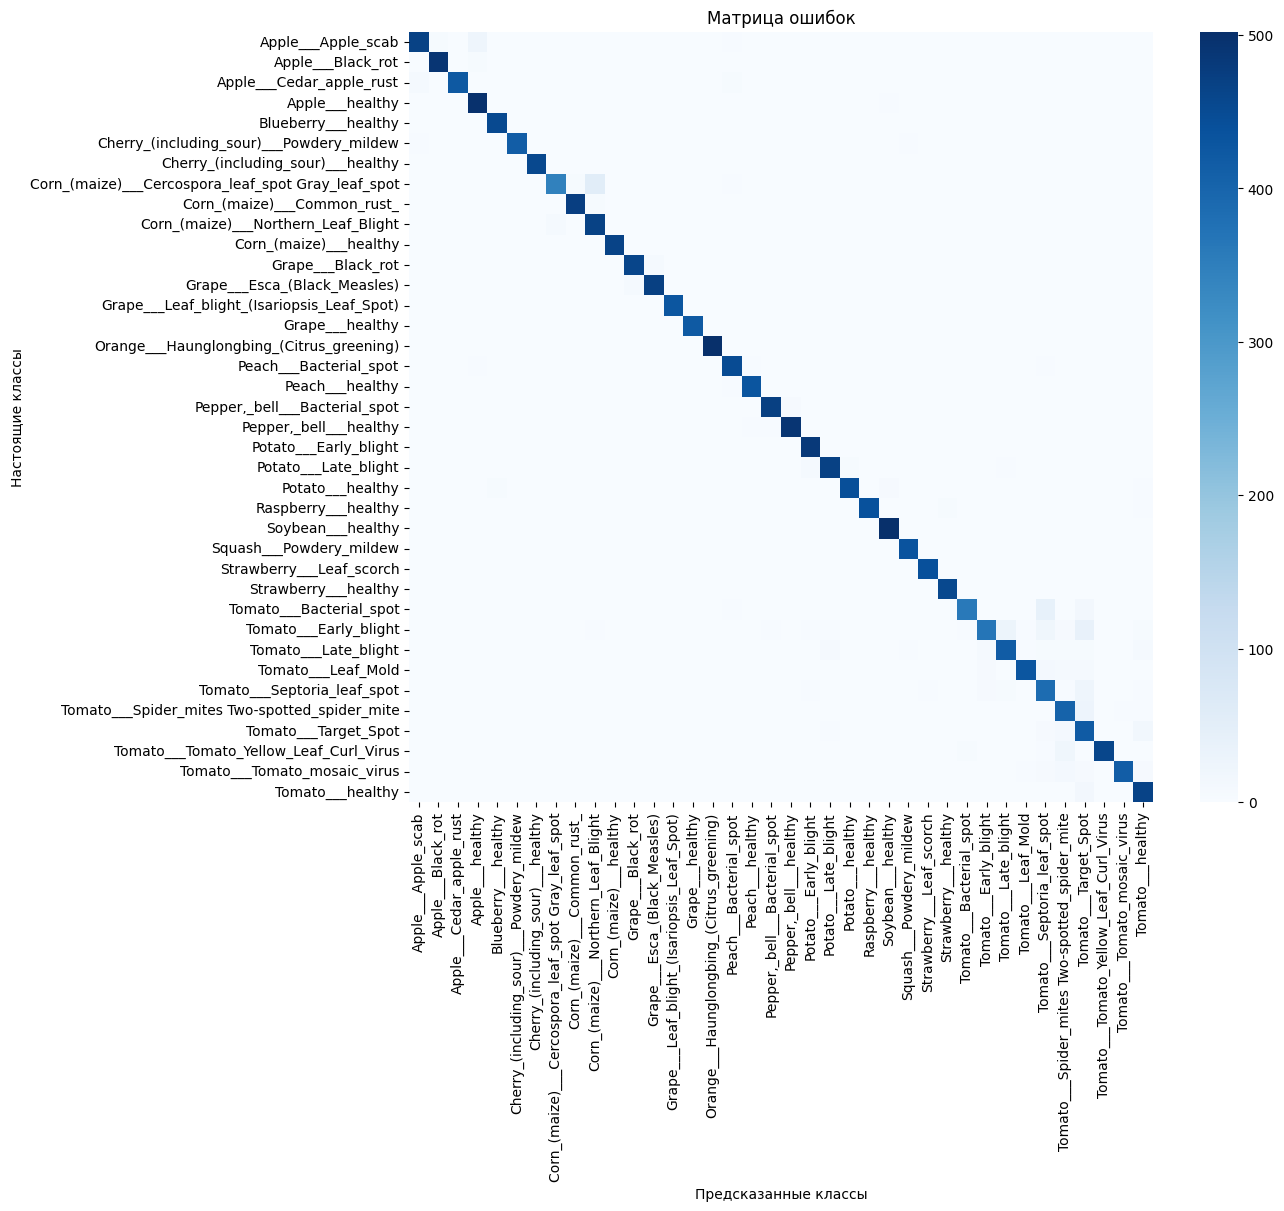


Отчет по классификации:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.93      0.95       504
                                 Apple___Black_rot       0.98      0.99      0.98       497
                          Apple___Cedar_apple_rust       1.00      0.96      0.98       440
                                   Apple___healthy       0.94      0.99      0.96       502
                               Blueberry___healthy       0.98      1.00      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.98      0.99       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.84      0.90       410
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       477
               Corn_(maize)___Northern_Leaf_Blight    

In [23]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Предсказания модели для теста
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Метки
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Предсказанные классы')
plt.ylabel('Настоящие классы')
plt.title('Матрица ошибок')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Отчет (precision, recall, f1-score)
print("\nОтчет по классификации:")
print(classification_report(y_true, y_pred, target_names=class_names))